In [ ]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
from IPython.display import Image
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

#Download required files for sentiment analysis
nltk.download([
"names",
"stopwords",
"state_union",
"twitter_samples",
"movie_reviews",
"averaged_perceptron_tagger",
"vader_lexicon",
"punkt",
], quiet=True)

In [2]:
# Import data from csv
df = pd.read_csv("consumer_complaints.csv", header = 0, low_memory=False)

In [3]:
#Get count by state and convert into usable dataframe
state_data = df['state'].value_counts().to_frame().reset_index()
state_data.columns = ['state', 'complaints']
print(state_data)

   state  complaints
0     CA       81700
1     FL       53673
2     TX       41352
3     NY       38266
4     GA       24548
..   ...         ...
57    MH          27
58    MP          19
59    AS          17
60    PW           9
61    AA           9

[62 rows x 2 columns]


However, this data must be normalized to be per-capita

In [4]:
populations = pd.read_csv("population.csv", header = 0)
state_data['per-capita'] = state_data.complaints.div(state_data.state.map(populations.set_index('code').pop_2014)) * 1000
print(state_data)

   state  complaints  per-capita
0     CA       81700    2.105534
1     FL       53673    2.698044
2     TX       41352    1.534001
3     NY       38266    1.937889
4     GA       24548    2.431135
..   ...         ...         ...
57    MH          27         NaN
58    MP          19         NaN
59    AS          17         NaN
60    PW           9         NaN
61    AA           9         NaN

[62 rows x 3 columns]


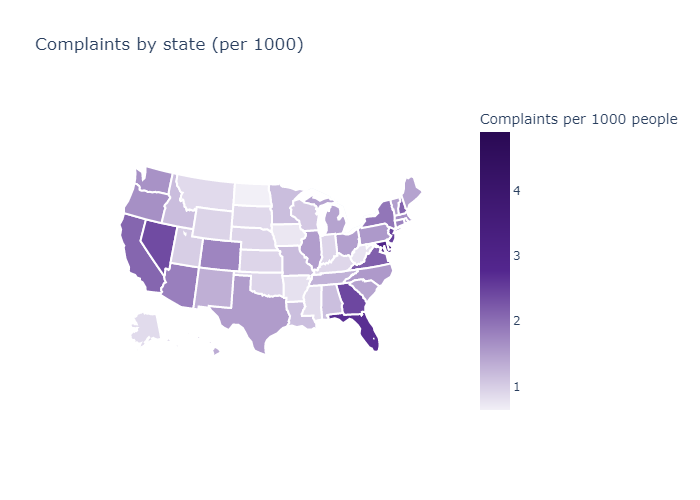

In [5]:
# Template from https://datascience.stackexchange.com/questions/9616/how-to-create-us-state-choropleth-map

scl = [[0.0, 'rgb(242,240,247)'], [0.5, 'rgb(84,39,143)'], [1.0, 'rgb(42, 10, 84)']]
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_data['state'],
        z = state_data['per-capita'],
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
         colorbar = dict(
            title = "Complaints per 1000 people"
        )

    ) ]
layout = dict(
        title = 'Complaints by state (per 1000)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
        ),
    )
fig = go.Figure(dict( data=data, layout=layout ))
#Convert to image (does not show on PDF or GitHub otherwise)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

From this graph, we can tell that the coastal areas seem to have a much higher complaints per capita rate. The bank would benefit from starting in the midwest region.

Now, analyze which products and banks the complaints were concentrated in.

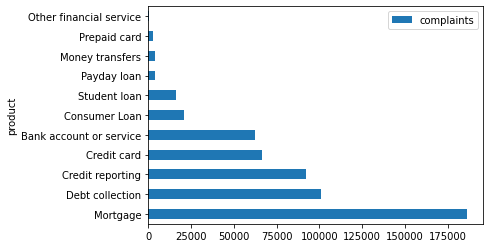

In [6]:
product_data = df['product'].value_counts().to_frame().reset_index()
product_data.columns = ['product', 'complaints']
product_data.set_index('product', inplace=True)
plot = product_data.plot.barh()

In [7]:
company_data = df['company'].value_counts().to_frame().reset_index()
company_data.columns = ['company', 'complaints']
company_data.set_index('company', inplace=True)
print(company_data)

                                       complaints
company                                          
Bank of America                             55998
Wells Fargo & Company                       42024
JPMorgan Chase & Co.                        33881
Equifax                                     31828
Experian                                    30905
...                                           ...
Capital Recovery Corporation                    1
Brian A. Blitz, P.A.                            1
Account Information Management, Corp.           1
Bristlecone, Inc.                               1
ICUL Service Corporation                        1

[3605 rows x 1 columns]


There are a lot of banks here, so let's just look at the top 20.

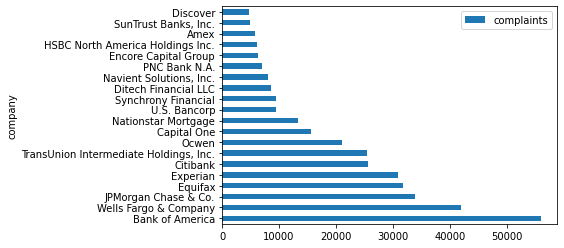

In [8]:
plot = company_data.head(20).plot.barh()

Next, create a model to predict if the customer will dispute a complaint.

The first step is to make the data usable for a model. Each datapoint must be a categorical or numerical variable. Therefore, the customer narrative can be quantified using nltk's sentiment analysis tool.

In [9]:
# Do a simple test for a statement with positive sentiment
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Wow, NLTK is really powerful!") 

{'neg': 0.0, 'neu': 0.295, 'pos': 0.705, 'compound': 0.8012}

We will use the compound score to determine the overall sentiment of the narrative.

In [10]:
# Apply the sentiment function to each narrative if it is not blank. If it's blank, set it to 0 (neutral)
def get_sentiment(text):
    if pd.isnull(text):
        return 0
    return sia.polarity_scores(text)['compound']
df['consumer_complaint_narrative']=df['consumer_complaint_narrative'].apply(lambda value: get_sentiment(value))

Text(0, 0.5, 'Proportion of Disputes')

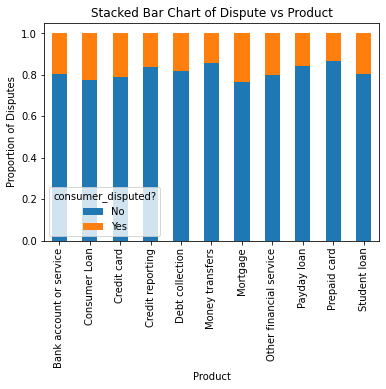

In [11]:
table  = pd.crosstab(df['product'],df['consumer_disputed?'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Dispute vs Product')
plt.xlabel('Product')
plt.ylabel('Proportion of Disputes')

There seems to be enough variance that the product could correlate to a customer dispute. Naively, this could be done manually for all the other variables, but that would be a very tedious process. Thankfully there are ways to automate this process.

Before we do that, we need to clean the data so that it's usable by the model. For logistic regression, each of the variables should be independent and related to the dependent variable. Since many of the sub_issue and sub_product values are blank, it makes to sense to drop those. Also, zip codes, dates, and complaint ids don't have anything to do with the customer disputes, so those can be removed as well.

Also, there are way too many companies for our model to train in a timely manner, so we will stick to complaints with the 20 most commmon companies.

In [12]:
data = df.copy()
companies = company_data.head(20).index.tolist()
data = data.loc[data['company'].isin(companies)]
data.drop(columns=['date_received', 'zipcode', 'date_sent_to_company', 'complaint_id', 'sub_product', 'sub_issue'], inplace= True)

To feed the data into the model, each of the categorical variables must be split into separate columns with a value of 1 or 0. 

In [13]:
categorical_vars=['product','issue','company','state','tags','submitted_via','consumer_consent_provided', 'company_response_to_consumer','timely_response', 'company_public_response']
for var in categorical_vars:
    # Append the categorical value to the column name. EX: state_IL, submitted_Web
    data = data.join(pd.get_dummies(data[var], prefix=var))
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in categorical_vars]
data=data[to_keep]

Finally, convert the Yes and No for disputes into 1's and 0's.

In [14]:
data['consumer_disputed?'] = data['consumer_disputed?'].apply(lambda value: 1 if value == 'Yes' else 0)

In [15]:
print(data['consumer_disputed?'].value_counts())

0    291041
1     75030
Name: consumer_disputed?, dtype: int64


In this dataset, there are many more records where a customer didn't dispute than where a customer did dispute. This causes an imbalance in the training data. Using a tool called SMOTE, synthetic samples can be created so that these are equal.

In [63]:
# Taken from https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
scaler = preprocessing.MinMaxScaler()
x = data.loc[:, data.columns != 'consumer_disputed?']
y = data.loc[:, data.columns == 'consumer_disputed?']

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_X = pd.DataFrame(scaler.fit_transform(os_data_X), columns=os_data_X.columns) # Scale data to have 0 mean and unit variance. Vastly speeds up computation
os_data_y= pd.DataFrame(data=os_data_y,columns=['consumer_disputed?'])

In [17]:
print("length of oversampled data is ",len(os_data_X))
print("Number of records where customer disputed",len(os_data_y[os_data_y['consumer_disputed?'] == 1]))
print("Number of records where didn't customer dispute",len(os_data_y[os_data_y['consumer_disputed?'] == 0]))

length of oversampled data is  407730
Number of records where customer disputed 203865
Number of records where didn't customer dispute 203865


Now, a feature selection algorithm called recursive feature elimination (RFE) can be used to find the trim the uneccesary columns.

In [18]:
logreg = LogisticRegression(solver = 'saga', n_jobs=-1) # n_jobs = -1 allows all CPU cores to be used
rfe = RFE(logreg)
lr = rfe.fit(os_data_X, os_data_y.values.ravel())

In [19]:
print(rfe.support_) # True or False depending if the variable is determined to be meaningful

[False False False False False False  True False  True  True  True False
  True  True  True False  True False  True  True False  True  True  True
  True  True  True False  True False  True  True False False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True False False  True False  True False  True
  True  True  True False  True False  True False False False  True  True
 False False  True  True  True False False  True  True False False False
  True False  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True False False  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False  True False
 False False False False False False False False Fa

In [20]:
useful = [value for value, keep in zip(data.columns.values, rfe.support_) if keep] 

To see which categorical values were most important, calculate what percentage of the possibilites appeared in the list above.

In [62]:
original_data = df.copy()
companies = company_data.head(20).index.tolist()
original_data = original_data.loc[original_data['company'].isin(companies)]
columns = ['product', 'issue',
 'consumer_complaint_narrative', 'company_public_response', 'company',
 'state', 'tags', 'consumer_consent_provided', 'submitted_via',
 'company_response_to_consumer', 'timely_response']

def get_proportion(label):
    options = original_data[label].nunique()
    important = 0
    for var in useful:
        if (label + '_') in var:
            important += 1
        elif important > 0: # We have passed the column pertaining to the current variable
            break
    return important/options

print(sorted([get_proportion(label), label] for label in columns))

[[0.0, 'company_public_response'], [0.0, 'consumer_complaint_narrative'], [0.08064516129032258, 'state'], [0.25, 'consumer_consent_provided'], [0.3333333333333333, 'tags'], [0.45454545454545453, 'product'], [0.5, 'timely_response'], [0.6914893617021277, 'issue'], [0.8333333333333334, 'submitted_via'], [0.95, 'company'], [1.0, 'company_response_to_consumer']]


Not surprisingly, the most important variable was the company's response to the consumer. If a company offers monetary relief, it's very unlikely for a customer to dispute. The company being an important factor is also not very surprising since the customer experience and compensation policies can vary by company standards. To see how each of these variables affect the dispute rate, the linear coefficients must be calculated.

In [ ]:
import statsmodels.api as sm

X=os_data_X[useful]
y=os_data_y['consumer_disputed?']
corr = X.corr()
logit_model=sm.Logit(y,X)
result=logit_model.fit(method='bfgs', maxiter=200)

There might still be a few variables that don't affect the disputes. The metrix for this is stored in the "P>|z|" column, which measures the chance that the variable has no effect on the end result. A threshold of 5% is common to keep a variable.

In [ ]:
results_as_html = result.summary().tables[1].as_html() # Use this to convert to pandas DataFrame
results = pd.read_html(results_as_html, header=0, index_col=0)[0]
results = results[results['P>|z|'] < 0.05] # Trim rows to ones with P|z| below 0.05, so that they have a significant impact on the dispute rate

X=os_data_X[results.index]
y=os_data_y['consumer_disputed?']
logit_model=sm.Logit(y,X)
result=logit_model.fit(method='bfgs', maxiter=200)

In [73]:
print(str(result.summary())[:2000]) # Whole summary is extremely long

                           Logit Regression Results                           
Dep. Variable:     consumer_disputed?   No. Observations:               407730
Model:                          Logit   Df Residuals:                   407646
Method:                           MLE   Df Model:                           83
Date:                Wed, 19 Jan 2022   Pseudo R-squ.:                 0.05231
Time:                        12:51:27   Log-Likelihood:            -2.6783e+05
converged:                      False   LL-Null:                   -2.8262e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
product_Debt collection                                          0.1154      0.030      3.885      0.000      

In [48]:
results_as_html = result.summary().tables[1].as_html() # Use this to convert to pandas DataFrame
results = pd.read_html(results_as_html, header=0, index_col=0)[0].reset_index()
results = results.rename(columns={'index':'variable'})
results = results.sort_values('coef')
print(results[results['variable'].str.contains('product_')][['variable','coef']])

                          variable    coef
2  product_Other financial service -0.6314
3             product_Student loan -0.3531
0          product_Debt collection  0.1154
1                 product_Mortgage  0.1445


If the bank wants to minimize disputes, student loans and other financial services were the best products to offer.

In [50]:
print(results[results['variable'].str.contains('company_response_to_consumer_')][['variable','coef']])

                                             variable    coef
81           company_response_to_consumer_In progress -5.4264
82     company_response_to_consumer_Untimely response -1.4360
79    company_response_to_consumer_Closed with relief -0.5430
77  company_response_to_consumer_Closed with monet... -0.4718
78  company_response_to_consumer_Closed with non-m... -0.0851
75                company_response_to_consumer_Closed  0.2215
76  company_response_to_consumer_Closed with expla...  0.6097
80  company_response_to_consumer_Closed without re...  0.6513


Unsusprisingly, cases that were closed with some type of relief were much less likely to be disputed than cases that did close with monetary relief.

Finally, it's important to test if these conclusions were made from a model that can accurately predict future occurences.

In [ ]:
logreg = LogisticRegression(solver='saga')
logreg.fit(X_train, y_train)

In [65]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


With an accuracy of 79%, this model can make quite accurate predictions about a customer's dispute, so the conclusions above can be considered valid.

**Final Thoughts**

Overall, this analysis was able to visualize the data with respect to different variables and create a model to predict the chance of a customer dispute. From this model, the optimal products were discovered along with each variable's effect on the dispute rate. Finally, this model proved to be quite accurate on unseen, test data, so the conclusions can be applied to scenarios outside of the dataset.

A few ideas that couldn't be implemented due to time or lack of data
\begin{itemize}
\item A tool where the company could have a complaint and then see the customer dispute chances based on their response.
\item A model to predict a company's response (this is not binary logistic regression), this is not very useful to an upcoming but could reveal interesting industry trends.
\item A way to quantify monetary compensation vs expected chance of a dispute. Then, using the average cost of a dispute, find the most efficient amount of compensation to give, if any.
\item A way to factor in certain keywords from the consumer complaint narrative rather than just the sentiment score.
\end{itemize}
